<a href="https://colab.research.google.com/github/odmina/misbehaving_armadillos/blob/main/Allen_Visual_Behavior_from_SDK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Overview**
The following notebook demonstrates how to load neural data for all imaging planes in one 2-photon imaging session into a single 'tidy' dataframe, make  simple event-triggered plots, and do some basic analysis using scikit-learn.

This is designed to demonstrate a simple method for interacting with the visual behavior data. Many aspects of the dataset are not explored here.

# Set up environment and import packages

We have built a package called `mindscope_utilities` which contains some useful convenience functions. The `allenSDK` is a dependency of this package and will be automatically installed when you install `mindscope_utilities` per the instrutions below.

We will first install `mindscope_utilities` into our colab environment by running the commands below. When this cell is complete, click on the `RESTART RUNTIME` button that appears at the end of the output. Note that running this cell will produce a long list of outputs and some error messages. Clicking `RESTART RUNTIME` at the end will resolve these issues. 

You can minimize the cell after you are done to hide the output. 

#### Install necessary packages

In [ ]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

     |████████████████████████████████| 1.6MB 14.0MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 73 kB 1.7 MB/s 
     |████████████████████████████████| 1.7 MB 22.3 MB/s 
     |████████████████████████████████| 4.3 MB 58.5 MB/s 
     |████████████████████████████████| 20.1 MB 1.5 MB/s 
     |████████████████████████████████| 3.4 MB 36.1 MB/s 
     |████████████████████████████████| 149 kB 45.2 MB/s 
     |████████████████████████████████| 3.4 MB 38.6 MB/s 
     |████████████████████████████████| 668 kB 47.2 MB/s 
     |████████████████████████████████| 10.4 MB 18.3 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 72 kB 994 kB/s 
     |████████████████████████████████| 128 kB 72.1 MB/s 
     |████████████████████████████████| 2.9 MB 46.7 MB/s 
     |████████████████████████████████| 98 kB 8.9 MB/s 
     |████████████████████

#### Next we will import packages we need later in the notebook

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)
hello

# Load the session and experiment summary tables

The AllenSDK provides functionality for downloading tables that describe all sessions and experiments (individual imaging planes) in the Visual Behavior 2P dataset. We first download the data cache:

In [ ]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

ophys_session_table.csv: 100%|██████████| 165k/165k [00:00<00:00, 722kMB/s]  
behavior_session_table.csv: 100%|██████████| 885k/885k [00:00<00:00, 3.52MMB/s] 
ophys_experiment_table.csv: 100%|██████████| 336k/336k [00:00<00:00, 1.56MMB/s] 


- `Ophys_session_table` contains metadata describing imaging sessions. If more than one plane was imaged during a session, one ophys session id will be associated multiple ophys experiment ids. Each ophys session id will also have a unique behavior session id. 
- `Behavior_session_table` contains metadata describing behavioral sessions, which may or may not be during imaging. Behavior session ids that do not have ophys session ids were training sessions. 
- `Ophys_experiment_table` contains metadata describing imaging experiments (aka imaging planes). When mesoscope is used, one ophys session may contain up to 8 unique experiments (two visual areas by four imaging depths). Some imaging planes may not be released due to quality control issues, thus each ophys session id is associated with anywhere from one to eight unique experiment ids. Ophys experiment ids are unique and do not repeat across sessions. To find the same imaging plane that was matched across multiple sessions, use the `ophys_container_id` column that can be found in both `ophys_session_table` and `ophys_experiment_table`. 

Then we can access the session and experiment tables directly.

Note that a 'session' is a single behavioral session. Sessions that are performed on the mesoscope will have multiple (up to 8) 'experiments' associated with them, where an experiment is a distinct imaging plane. 

In [ ]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()
behavior_session_table = cache.get_behavior_session_table()

We can then view the contents of the session table. Note that this contains a lot of useful metadata about each session. One of the columns, `ophys_experiment_id` provides a list of the experiments (aka imaging planes) that are associated with each session.

In [ ]:
session_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,behavior_session_id,ophys_experiment_id,ophys_container_id,project_code,date_of_acquisition,session_type
ophys_session_id,,,,,,,,,,,,,,,,,,,
951410079,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951520319,"[951980471, 951980473, 951980475, 951980479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-20 09:45:29.897856,OPHYS_1_images_A
952430817,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,209.0,Sst-IRES-Cre,GCaMP6f,2.0,0,66.0,1,952554548,"[953659743, 953659745, 953659749, 953659752]","[1018028339, 1018028345, 1018028354, 1018028357]",VisualBehaviorMultiscope,2019-09-23 08:13:07.627573,OPHYS_2_images_A_passive
954954402,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,Sst-IRES-Cre,GCaMP6f,3.0,0,67.0,2,953982960,"[958527464, 958527471, 958527474, 958527479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-24 16:00:00.000000,OPHYS_3_images_A
955775716,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,212.0,Sst-IRES-Cre,GCaMP6f,3.0,1,68.0,3,956010809,"[956941841, 956941844, 956941846]","[1018028339, 1018028342, 1018028345]",VisualBehaviorMultiscope,2019-09-26 08:44:37.199778,OPHYS_3_images_A
957020350,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,213.0,Sst-IRES-Cre,GCaMP6f,4.0,0,0.0,4,957032492,"[957759562, 957759564, 957759566, 957759570, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-27 08:28:05.415005,OPHYS_4_images_B


The experiment table has one row per experiment. Note that the `ophys_session_id` column links each experiment to its associated session in the session_table.

In [ ]:
experiment_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,
951980471,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028342,VisualBehaviorMultiscope,150,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085394308
951980484,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028351,VisualBehaviorMultiscope,75,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400876
951980473,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028345,VisualBehaviorMultiscope,225,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400919
951980479,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028354,VisualBehaviorMultiscope,150,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400977
951980475,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028339,VisualBehaviorMultiscope,75,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400920


## Load behavior data

In [ ]:
behavior_session_table.head()

# Load one example session
We are going to select one session from this table, session 854060305. This is a session with Sst-IRES-Cre mouse, which expressed GCaMP6f in Sst+ inhibitory interneurons. There were 6 simultaneously acquired imaging planes for this session. 
We can view metadata for this session as follows:

In [ ]:
ophys_session_id = 854060305
session_table.loc[ophys_session_id]

equipment_name                                                                MESO.1
full_genotype                          Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
mouse_id                                                                      440631
reporter_line                                             Ai148(TIT2L-GC6f-ICL-tTA2)
driver_line                                                           [Sst-IRES-Cre]
sex                                                                                M
age_in_days                                                                      129
cre_line                                                                Sst-IRES-Cre
indicator                                                                    GCaMP6f
session_number                                                                     6
prior_exposures_to_session_type                                                    0
prior_exposures_to_image_set                                     

# Download all associated experiments

Each session consists of one or more 'experiments', in which each experiment is a single imaging plane

Each mesoscope session has up to 8 experiments associated with the session. We will load all sessions into a dictionary with the experiment IDs as the keys

The first time that this cell is run, the associated NWB files will be downloaded to your local `data_storage_directory`. Subsequent runs of this cell will be faster since the data will already be cached locally.

In [ ]:
experiments = {}
ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

## Load neural data into memory


The cell below will load the neural data into memory in the pandas 'tidy' format by iterating over each of the 6 experiments and using some helpful tools from the `visual_behavior_ophys` module of the `mindscope_utilities` package that was imported above as `ophys`. 

It will also include a subset of metadata from `ophys_experiment_table` to facilitate splitting by depth, structure (aka cortical area), cre line (aka cell class), etc.

Note that 'tidy' data means that each row represents only one observation. Observations are stacked vertically. Thus, the `timestamps` colums will repeat for every cell in the dataset.

In [ ]:
neural_data = []
for ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)
    
    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

100%|██████████| 6/6 [00:32<00:00,  5.48s/it]


We can then look at some attributes of the `neural_data` dataframe we have created.

It is ~2.5 million rows long:

In [ ]:
len(neural_data)

2561543

It is so long because has one row for each timestamp for each cell. 

Below are the first 5 entries. Again, note that the `tidy` format means that each row has only one observation, which represents a single GCaMP6 fluorescnce value for a single neuron.

In [ ]:
neural_data.head()

,timestamps,cell_roi_id,cell_specimen_id,dff,events,filtered_events,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,10.52216,1080852071,1086550481,0.400583,0.0,0.0,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
1,10.61538,1080852071,1086550481,0.126125,0.0,0.0,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
2,10.70860,1080852071,1086550481,-0.083087,0.0,0.0,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
3,10.80182,1080852071,1086550481,0.158960,0.0,0.0,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M
4,10.89504,1080852071,1086550481,0.301507,0.0,0.0,854759890,854060305,VISp,275,MESO.1,Sst-IRES-Cre,440631,M


- The `cell_roi_id` column contains unique roi ids for all cells in a given experiment, which do not repeat across ophys sessions. 
- The `cell_specimen_id` column contains unique ids for cells that were matched across ophys sessions. Thus, a cell that was imaged in more than one session has multiple roi ids but one cell specimen id. 

# Examine Cell IDs
We can get the unique Cell IDs in our dataset as follows:

In [ ]:
cell_ids = neural_data['cell_specimen_id'].unique()
print('there are {} unique cells'.format(len(cell_ids)))
print('cell ids are: {}'.format(cell_ids))

there are 53 unique cells
cell ids are: [1086550481 1086551114 1086551301 1086557083 1086557639 1086559064
 1086558114 1086558224 1086558510 1086559206 1086557304 1086557208
 1086560061 1086559681 1086559885 1086559968 1086557470 1086547796
 1086547993 1086548118 1086554566 1086556653 1086558574 1086552296
 1086558071 1086556532 1086555222 1086558701 1086557434 1086556317
 1086555835 1086549726 1086553836 1086551540 1086551151 1086550544
 1086552709 1086553271 1086553602 1086555553 1086548072 1086553899
 1086547630 1086549303 1086549491 1086549813 1086549949 1086548658
 1086548969 1086551457 1086551645 1086550990 1086551209]


If we wanted to get the timeseries for one cell, we could query the `neural_data` dataframe. For example, to get the full timeseries for the cell with `cell_specimen_id = 1086557208`:

In [ ]:
single_cell_timeseries = neural_data.query('cell_specimen_id == 1086557208')
single_cell_timeseries.head()

,timestamps,cell_roi_id,cell_specimen_id,dff,events,filtered_events,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,10.52216,1080855724,1086557208,0.218961,0.0,0.0,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M
1,10.61538,1080855724,1086557208,0.232865,0.0,0.0,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M
2,10.70860,1080855724,1086557208,-0.050186,0.0,0.0,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M
3,10.80182,1080855724,1086557208,0.239468,0.0,0.0,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M
4,10.89504,1080855724,1086557208,0.226356,0.0,0.0,854759894,854060305,VISp,179,MESO.1,Sst-IRES-Cre,440631,M


Each cell has three types of traces:
- `dff` column is the Calcium fluorescence signal, normalized to background fluorescence.
- `events` column is deconvolved events from dff trace, which approximates neural firing rate and removes the slow decay of the Calcium signal (for more details, you can read EVENT DETECTION section in [Visual Behavior whitepaper](https://portal.brain-map.org/explore/circuits/visual-behavior-2p)).
- `filtered_events` column is events smoothed with a half-gaussian kernel. 

We can then plot DeltaF/F for this cell for the full experiment as follows:

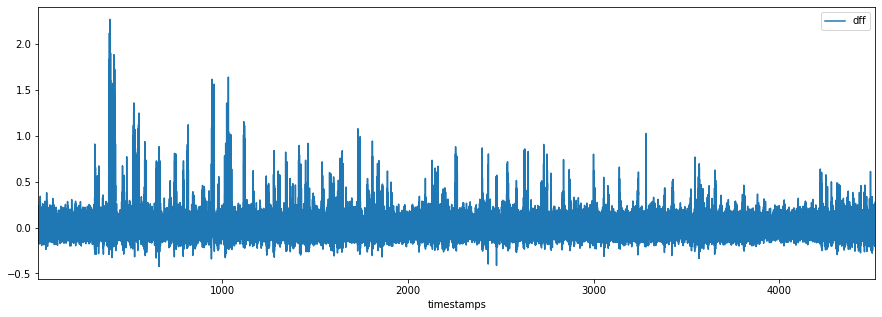

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
single_cell_timeseries.plot(
    x = 'timestamps',
    y = 'dff',
    ax = ax
)

# Load stimulus data into memory
The stimulus table is shared across all experiments (imaging planes) in a session. We can therefore use the stimulus table for just one experiment.

We are going to drop the `image_set` column because it is not informative for our purposes. We can then view the first 10 rows of the stimulus table.

In [ ]:
stimulus_table = experiments[ophys_experiment_ids[0]].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
stimulus_table.head(10)

,duration,end_frame,image_index,image_name,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,
0,0.25021,18001.0,0,im000,0,False,17986,310.55053,310.80074,False
1,0.25020,18046.0,0,im000,1,False,18031,311.30115,311.55135,False
2,0.25021,18091.0,0,im000,2,False,18076,312.05179,312.30200,False
3,0.25020,18136.0,0,im000,3,False,18121,312.80242,313.05262,False
4,0.25021,18181.0,0,im000,4,False,18166,313.55303,313.80324,False
5,0.25023,18226.0,0,im000,5,False,18211,314.30362,314.55385,False
6,0.25020,18271.0,0,im000,6,False,18256,315.05426,315.30446,False
7,0.25020,18316.0,0,im000,7,False,18301,315.80487,316.05507,False
8,0.25022,18361.0,0,im000,8,False,18346,316.55547,316.80569,False
